In [107]:
# set up imports
import pandas as pd, numpy as np, seaborn as sns
from tabulate import tabulate
import statsmodels
import arch
import matplotlib
matplotlib.use('qt5agg')

# configure plot style
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["figure.figsize"] = (9.5,4.15)
plt.rcParams['figure.constrained_layout.use'] = False
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['lines.linewidth'] = 0.8
save_plot_to =  r'C:\\Users\joche\OneDrive\03 TUM - TUM-BWL\Semester 8\01 Bachelorarbeit\04 Results\Plots/'

In [108]:
# load data and crop to start_date:end_date
start_date = '2015-08-07'
end_date = '2020-06-26'
idx = pd.date_range(start_date, end_date)
index_name = 'date'
mydateparser = lambda x: pd.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
mydateparser1 = lambda x: pd.datetime.strptime(str(x), '%Y-%m-%d')

# btc
btc = pd.read_excel('Data/BTC_closing.xlsx', parse_dates=[0], index_col=0, date_parser=mydateparser)[start_date:end_date]
btc.index.name = index_name
btc.columns = ['btc']

# usd_eur
usd_eur = pd.read_excel('Data/DEXUSEU.xls', parse_dates=[0], index_col=0, skiprows=10, date_parser=mydateparser)[start_date:end_date]
usd_eur.index.name = index_name
usd_eur.columns = ['usd_eur']
usd_eur = usd_eur.loc[(usd_eur!=0).any(1)]

# tot_btc: only weekly data - missing values interpolated
tot_btc = pd.read_csv('Data/total-bitcoins', index_col=0)[start_date:end_date]
tot_btc.index = pd.DatetimeIndex(tot_btc.index, normalize=True).normalize()
tot_btc.index.name = index_name
tot_btc = tot_btc.reindex(idx, fill_value=None)
tot_btc.interpolate(method='time', inplace=True, limit_direction='both')
tot_btc.columns = ['tot_btc']

# hs_rate: only weekly data - missing values interpolated
hs_rate = pd.read_csv('Data/hash-rate', index_col=0)[start_date:end_date]
hs_rate.index = pd.DatetimeIndex(hs_rate.index, normalize=True).normalize()
hs_rate.index.name = index_name
hs_rate = hs_rate.reindex(idx, fill_value=None)
hs_rate.interpolate(method='time', inplace=True, limit_direction='both')
hs_rate.columns = ['hs_rate']

# eth
eth = pd.read_excel('Data/ETH.xlsx', parse_dates=[0], index_col=0, date_parser=mydateparser, usecols='A,E')[start_date:end_date]
eth.index.name = index_name
eth.columns = ['eth']

# ggl_trends: only weekly data - missing values interpolated
# ggl_trends: weighted average of 15 countries
ggl_trends = pd.read_csv('Data/googletrends.txt', index_col=0)[start_date:end_date]
ggl_trends.index = pd.DatetimeIndex(ggl_trends.index, normalize=True).normalize()
ggl_trends.index.name = index_name
ggl_trends = ggl_trends.reindex(idx, fill_value=None)
ggl_trends.interpolate(method='time', inplace=True, limit_direction='both')
ggl_trends['btc-average'] = np.round(ggl_trends.sum(axis=1)/15)
ggl_trends = ggl_trends[['btc-average']].copy()
ggl_trends.columns = ['ggl_trends']

# wiki_views: sum of 99 countries
wiki_views = pd.read_excel('Data/wikipedia.xlsx', parse_dates=[0], index_col=0, date_parser=mydateparser1)[start_date:end_date]
wiki_views.index = pd.DatetimeIndex(wiki_views.index, normalize=True).normalize()
wiki_views.index.name = index_name
wiki_views['wiki-total'] = np.round(wiki_views.sum(axis=1))
wiki_views = wiki_views[['wiki-total']].copy()
wiki_views.columns = ['wiki_views']

# wti_oil
oil_wti = pd.read_excel('Data/DCOILWTICO.xls', parse_dates=[0], index_col=0, skiprows=10, date_parser=mydateparser)[start_date:end_date]
oil_wti.index = pd.DatetimeIndex(oil_wti.index, normalize=True).normalize()
oil_wti.index.name = index_name
oil_wti.columns = ['oil_wti']
oil_wti = oil_wti.loc[(oil_wti!=0).any(1)]

# gold
gold = pd.read_excel('Data/GOLDAMGBD228NLBM10AM.xls', parse_dates=[0], index_col=0, skiprows=10, date_parser=mydateparser)[start_date:end_date]
gold.index = pd.DatetimeIndex(gold.index, normalize=True).normalize()
gold.index.name = index_name
gold.columns = ['gold']
gold = gold.loc[(gold!=0).any(1)]

# sp500
sp500 = pd.read_excel('Data/SP500.xls', parse_dates=[0], index_col=0, skiprows=10, date_parser=mydateparser)[start_date:end_date]
sp500.index = pd.DatetimeIndex(sp500.index, normalize=True).normalize()
sp500.index.name = index_name
sp500.columns = ['sp500']
sp500 = sp500.loc[(sp500!=0).any(1)]

# sse 
sse = pd.read_excel('Data/SSEcomposite.xlsx', parse_dates=[0], index_col=0, header=0, date_parser=mydateparser)[start_date:end_date]
sse.index = pd.DatetimeIndex(sse.index, normalize=True).normalize()
sse.index.name = index_name
sse = sse[['Zuletzt']].copy()
sse.columns = ['sse']

# ffd_rate
ffd_rate = pd.read_excel('Data/DFF.xls', parse_dates=[0], index_col=0, skiprows=10, date_parser=mydateparser)[start_date:end_date]
ffd_rate.index = pd.DatetimeIndex(ffd_rate.index, normalize=True).normalize()
ffd_rate.index.name = index_name
ffd_rate.columns = ['ffd_rate']

In [109]:
# merge data to one df (inner join)
from functools import reduce
temp = [btc,tot_btc,hs_rate,eth,ggl_trends,wiki_views,usd_eur,oil_wti,
              gold,sp500,sse,ffd_rate]
df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), temp)
df

,btc,tot_btc,hs_rate,eth,ggl_trends,wiki_views,usd_eur,oil_wti,gold,sp500,sse,ffd_rate
date,,,,,,,,,,,,
2015-08-07,279.58,1.447762e+07,3.775640e+05,2.770000,2.0,15560,1.0958,43.87,1091.35,2077.57,3744.20,0.14
2015-08-10,264.47,1.448130e+07,3.687855e+05,0.708448,2.0,15113,1.0994,44.94,1094.80,2104.18,3928.42,0.14
2015-08-11,270.39,1.448498e+07,3.754390e+05,1.070000,2.0,15320,1.1042,43.11,1113.25,2084.07,3927.91,0.15
2015-08-12,266.38,1.448865e+07,3.820926e+05,1.220000,2.0,15255,1.1198,43.22,1116.80,2086.05,3886.32,0.15
2015-08-13,264.08,1.449229e+07,3.887461e+05,1.830000,2.0,23711,1.1144,42.27,1117.35,2083.39,3954.56,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-18,9411.84,1.840797e+07,1.090229e+08,232.100000,10.0,16234,1.1216,38.79,1732.65,3115.34,2939.32,0.09
2020-06-19,9288.02,1.840862e+07,1.074749e+08,227.140000,10.0,15721,1.1189,39.72,1728.55,3097.74,2967.63,0.09
2020-06-22,9648.72,1.841192e+07,1.074657e+08,242.530000,10.0,16482,1.1260,40.60,1745.45,3117.86,2965.27,0.08


In [110]:
# define plotting function
import matplotlib.dates as mdates
def plot_df(df):
    fig_i, axs = plt.subplots(4,3, figsize=(9.5,4.15))
    for i, ax in enumerate(axs.flatten()):
        data = df[df.columns[i]]
        ax.plot(data, color='black')
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m"))
        #ax.spines['top'].set_alpha(0)
        ax.tick_params(labelsize=8)
    plt.tight_layout()
    return fig_i

In [111]:
# plot raw time series
fig_1 = plot_df(df)

In [112]:
# take log of time series and relabel columns
df_log = np.log(df)
new_cols = list()
for i in df_log.columns:
    new_cols.append(i+'_log')
df_log.columns = new_cols

# plot log time series
fig_2 = plot_df(df_log)

# fill na value of negative oil price on 2020-04-20 with 0
df_log.fillna(value=0, inplace=True)

C:\Users\joche\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [113]:
# plot correlation matrix as latex table
corr = df.corr().round(3)
print(tabulate(corr, headers=corr.columns, showindex=True, tablefmt="latex"))

\begin{tabular}{lrrrrrrrrrrrr}
\hline
            &    btc &   tot\_btc &   hs\_rate &   eth &   ggl\_trends &   wiki\_views &   usd\_eur &   oil\_wti &   gold &   sp500 &    sse &   ffd\_rate \\
\hline
 btc        &  1     &     0.756 &     0.65  & 0.736 &        0.711 &        0.38  &     0.463 &     0.425 &  0.575 &   0.823 & -0.13  &      0.564 \\
 tot\_btc    &  0.756 &     1     &     0.881 & 0.361 &        0.33  &       -0.034 &     0.145 &     0.287 &  0.765 &   0.929 & -0.464 &      0.642 \\
 hs\_rate    &  0.65  &     0.881 &     1     & 0.144 &        0.157 &       -0.223 &    -0.068 &     0.046 &  0.831 &   0.832 & -0.463 &      0.392 \\
 eth        &  0.736 &     0.361 &     0.144 & 1     &        0.653 &        0.484 &     0.772 &     0.515 &  0.175 &   0.474 &  0.17  &      0.409 \\
 ggl\_trends &  0.711 &     0.33  &     0.157 & 0.653 &        1     &        0.799 &     0.469 &     0.236 &  0.233 &   0.377 &  0.186 &      0.277 \\
 wiki\_views &  0.38  &    -0.034 &    

In [114]:
# plot correlation matrix as heatmap
corr = df.corr()
# more html colors here: https://www.w3schools.com/colors/colors_names.asp
# pal = sns.light_palette('lightgrey', as_cmap=True)
ax = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, 
            annot_kws={'size':7}, vmin=-1, center=0, vmax=1, cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
fig_3 = plt.gcf()
fig_3.set_size_inches(9.5,4.15)
plt.tick_params(axis='both', which='major', labelsize=7.5, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.xticks(fontsize=7.5, rotation=1)
plt.yticks(fontsize=7.5)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]), <a list of 12 Text yticklabel objects>)

In [115]:
# split df in df_train and df_test set
train_size = int(len(df) * 0.8)
df_train, df_test = df[0:train_size], df[train_size:]
print('df:\t\t',len(df))
print('df_train:\t',len(df_train))
print('df_test:\t',len(df_test))
print('Sum train+test:\t', len(df_train)+len(df_test))

df:		 1112
df_train:	 889
df_test:	 223
Sum train+test:	 1112


In [116]:
# take log of df_train: df_train_log
df_train_log = np.log(df_train)

# relabel columns
new_cols = list()
for i in df_train_log.columns:
    new_cols.append(i+'_log')
df_train_log.columns = new_cols

df_train_log

,btc_log,tot_btc_log,hs_rate_log,eth_log,ggl_trends_log,wiki_views_log,usd_eur_log,oil_wti_log,gold_log,sp500_log,sse_log,ffd_rate_log
date,,,,,,,,,,,,
2015-08-07,5.633288,16.488115,12.841495,1.018847,0.693147,9.652459,0.091485,3.781231,6.995171,7.638954,8.227963,-1.966113
2015-08-10,5.577728,16.488369,12.817970,-0.344679,0.693147,9.623311,0.094765,3.805328,6.998327,7.651681,8.275993,-1.966113
2015-08-11,5.599865,16.488622,12.835851,0.067659,0.693147,9.636914,0.099121,3.763755,7.015039,7.642078,8.275863,-1.897120
2015-08-12,5.584924,16.488876,12.853418,0.198851,0.693147,9.632663,0.113150,3.766303,7.018223,7.643028,8.265218,-1.897120
2015-08-13,5.576252,16.489127,12.870682,0.604316,0.693147,10.073694,0.108316,3.744078,7.018715,7.641752,8.282625,-1.897120
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-25,9.375085,16.693548,17.849020,5.762460,3.135494,10.372115,0.129799,4.054043,7.265115,7.978441,8.000373,0.867100
2019-06-26,9.473952,16.693647,17.872962,5.819341,3.091042,10.785725,0.130151,4.080415,7.249037,7.977206,7.998429,0.867100
2019-06-27,9.322133,16.693745,17.883926,5.684498,3.044522,10.611745,0.128569,4.080584,7.245833,7.981022,8.005297,0.867100


In [117]:
# plot df_train_log
fig_4 = plot_df(df_train_log)

In [118]:
# adf- and pp-test of a df
from arch.unitroot import ADF, PhillipsPerron
def stationarity_tests(df, latex):
    for col in df:
        adf = ADF(df[col])
        pp = PhillipsPerron(df[col])
        
        if latex is False:
            # write summary as plain text to std.out
            print('Timeseries:\t',col,'\n',
                  adf.summary(),'\n\n',pp.summary(),'\n\n\n')
        else:
            # write summary as latex to file
            with open(save_plot_to + 'Stationarity_Tests_LaTeX.txt', 'a') as myfile:
                myfile.write('Timeseries:\t'+col+'\n'
                         +adf.summary().as_latex()+'\n\n'
                         +pp.summary().as_latex()+'\n\n\n')

In [119]:
# adf- and pp-test of df_train_log
stationarity_tests(df_train_log, latex=False)

Timeseries:	 btc_log 
    Augmented Dickey-Fuller Results   
Test Statistic                 -0.883
P-value                         0.794
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

      Phillips-Perron Test (Z-tau)    
Test Statistic                 -0.931
P-value                         0.778
Lags                               21
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 



Timeseries:	 tot_btc_log 
    Augmented Dickey-Fuller Results   
Test Statistic                 -2.824
P-value                         0.055
Lags                               19
-------------------------------------

Trend: Constan

In [120]:
# first differences of df_train_log: df_train_log_diff
df_train_log_diff = df_train_log.diff()

# relabel columns
new_cols = list()
for i in df_train_log_diff.columns:
    new_cols.append(i+'_diff')
df_train_log_diff.columns = new_cols

df_train_log_diff

,btc_log_diff,tot_btc_log_diff,hs_rate_log_diff,eth_log_diff,ggl_trends_log_diff,wiki_views_log_diff,usd_eur_log_diff,oil_wti_log_diff,gold_log_diff,sp500_log_diff,sse_log_diff,ffd_rate_log_diff
date,,,,,,,,,,,,
2015-08-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-10,-0.055561,0.000254,-0.023525,-1.363526,0.000000,-0.029148,0.003280,0.024098,0.003156,0.012727,0.048029,0.000000
2015-08-11,0.022138,0.000254,0.017881,0.412337,0.000000,0.013604,0.004357,-0.041573,0.016712,-0.009603,-0.000130,0.068993
2015-08-12,-0.014942,0.000254,0.017567,0.131192,0.000000,-0.004252,0.014029,0.002548,0.003184,0.000950,-0.010645,0.000000
2015-08-13,-0.008672,0.000251,0.017264,0.405465,0.000000,0.441032,-0.004834,-0.022226,0.000492,-0.001276,0.017407,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-25,0.068426,0.000099,0.024530,0.024534,-0.083382,-0.007638,-0.000615,-0.001734,0.017002,-0.009542,-0.008708,0.000000
2019-06-26,0.098867,0.000098,0.023942,0.056881,-0.044452,0.413610,0.000351,0.026371,-0.016078,-0.001235,-0.001943,0.000000
2019-06-27,-0.151819,0.000098,0.010964,-0.134843,-0.046520,-0.173980,-0.001582,0.000169,-0.003204,0.003816,0.006868,0.000000


In [121]:
# plot df_train_log_diff
fig_5 = plot_df(df_train_log_diff[1:])

In [122]:
# adf- and pp-test of df_train_log_diff
stationarity_tests(df_train_log_diff[1:], latex=False)

Timeseries:	 btc_log_diff 
    Augmented Dickey-Fuller Results   
Test Statistic                -29.318
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

      Phillips-Perron Test (Z-tau)    
Test Statistic                -29.679
P-value                         0.000
Lags                               21
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 



Timeseries:	 tot_btc_log_diff 
    Augmented Dickey-Fuller Results   
Test Statistic                 -2.820
P-value                         0.055
Lags                               18
-------------------------------------

Tren

In [123]:
# granger causality test on a df
# code taken from: https://stackoverflow.com/questions/58005681/is-it-possible-to-run-a-vector-autoregression-analysis-on-a-large-gdp-data-with
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=15
test = 'ssr-chi2test'
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset

In [124]:
# perform granger causality test each on each based on df_train_log_diff
granger_causality_matrix = grangers_causality_matrix(df_train_log_diff[1:], variables = df_train_log_diff.columns)
granger_causality_matrix.round(4)

,btc_log_diff_x,tot_btc_log_diff_x,hs_rate_log_diff_x,eth_log_diff_x,ggl_trends_log_diff_x,wiki_views_log_diff_x,usd_eur_log_diff_x,oil_wti_log_diff_x,gold_log_diff_x,sp500_log_diff_x,sse_log_diff_x,ffd_rate_log_diff_x
btc_log_diff_y,1.0000,0.5272,0.0225,0.0784,0.0055,0.2011,0.2354,0.4655,0.3461,0.1532,0.6332,0.4867
tot_btc_log_diff_y,0.6692,1.0000,0.1870,0.0567,0.1614,0.0000,0.0362,0.0008,0.4126,0.0181,0.0009,0.0000
hs_rate_log_diff_y,0.0850,0.0000,1.0000,0.0223,0.0467,0.0797,0.0150,0.0029,0.0229,0.1382,0.4550,0.1592
eth_log_diff_y,0.0038,0.1471,0.1155,1.0000,0.4148,0.1589,0.0975,0.5212,0.2341,0.1532,0.0184,0.0384
ggl_trends_log_diff_y,0.0750,0.0225,0.1172,0.2559,1.0000,0.0050,0.0417,0.1165,0.1172,0.1349,0.4080,0.0079
wiki_views_log_diff_y,0.0001,0.1781,0.1756,0.4502,0.0000,1.0000,0.4715,0.0284,0.1477,0.1051,0.0831,0.0207
usd_eur_log_diff_y,0.2558,0.0974,0.5620,0.0306,0.1226,0.5229,1.0000,0.0175,0.1499,0.2106,0.0364,0.0024
oil_wti_log_diff_y,0.0331,0.1157,0.1933,0.0012,0.0271,0.6849,0.2089,1.0000,0.3901,0.0051,0.0368,0.0561
gold_log_diff_y,0.5008,0.0778,0.1955,0.0814,0.3031,0.7110,0.0000,0.0077,1.0000,0.0259,0.0947,0.1240
sp500_log_diff_y,0.1098,0.4486,0.0199,0.0004,0.0204,0.0668,0.1182,0.4076,0.1643,1.0000,0.0000,0.0002


In [125]:
# plot granger causality matrix as latex table
print(tabulate(granger_causality_matrix, headers=granger_causality_matrix.columns, showindex=True, tablefmt="latex"))

\begin{tabular}{lrrrrrrrrrrrr}
\hline
                       &   btc\_log\_diff\_x &   tot\_btc\_log\_diff\_x &   hs\_rate\_log\_diff\_x &   eth\_log\_diff\_x &   ggl\_trends\_log\_diff\_x &   wiki\_views\_log\_diff\_x &   usd\_eur\_log\_diff\_x &   oil\_wti\_log\_diff\_x &   gold\_log\_diff\_x &   sp500\_log\_diff\_x &   sse\_log\_diff\_x &   ffd\_rate\_log\_diff\_x \\
\hline
 btc\_log\_diff\_y        &           1      &               0.5272 &               0.0225 &           0.0784 &                  0.0055 &                  0.2011 &               0.2354 &               0.4655 &            0.3461 &             0.1532 &           0.6332 &                0.4867 \\
 tot\_btc\_log\_diff\_y    &           0.6692 &               1      &               0.187  &           0.0567 &                  0.1614 &                  0      &               0.0362 &               0.0008 &            0.4126 &             0.0181 &           0.0009 &                0      \\
 hs\_rate\_log\_diff\_y    & 

In [89]:
# plot granger causality matrix as heatmap
ax = sns.heatmap(granger_causality_matrix, xticklabels=granger_causality_matrix.columns.values, yticklabels=granger_causality_matrix.index.values,
                 annot=True, annot_kws={'size':7}, vmin=0, vmax=1, cmap="YlGnBu_r")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
fig_6 = plt.gcf()
fig_6.set_size_inches(9.5,4.15)
plt.tick_params(axis='both', which='major', labelsize=7, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.xticks(fontsize=7, rotation=45)
plt.yticks(fontsize=7)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]), <a list of 12 Text yticklabel objects>)

In [130]:
# Initiiere VAR-Modell
from statsmodels.tsa.vector_ar.var_model import VAR
# Order selection
var_model = VAR(endog=df_train_log_diff[1:])
var_order_res = var_model.select_order(15).summary()
res_as_html = var_order_res.as_html()
df_var_order = pd.read_html(res_as_html, header=0, index_col=0)[0]
df_var_order

C:\Users\joche\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


'AIC'

In [131]:
# plot df_var_order as latex table
print(tabulate(df_var_order, headers=df_var_order.columns, showindex=True, tablefmt="latex"))

\begin{tabular}{rllll}
\hline
    & AIC     & BIC     & FPE        & HQIC    \\
\hline
  0 & -95.56  & -95.49* & 3.163e-42  & -95.53  \\
  1 & -95.89  & -95.04  & 2.261e-42  & -95.57* \\
  2 & -95.84  & -94.20  & 2.375e-42  & -95.22  \\
  3 & -95.84  & -93.41  & 2.381e-42  & -94.91  \\
  4 & -95.86  & -92.64  & 2.344e-42  & -94.63  \\
  5 & -95.97* & -91.96  & 2.108e-42* & -94.43  \\
  6 & -95.85  & -91.06  & 2.377e-42  & -94.02  \\
  7 & -95.76  & -90.19  & 2.599e-42  & -93.63  \\
  8 & -95.67  & -89.31  & 2.858e-42  & -93.24  \\
  9 & -95.59  & -88.44  & 3.103e-42  & -92.86  \\
 10 & -95.54  & -87.60  & 3.285e-42  & -92.50  \\
 11 & -95.46  & -86.74  & 3.570e-42  & -92.13  \\
 12 & -95.41  & -85.90  & 3.810e-42  & -91.77  \\
 13 & -95.30  & -85.00  & 4.303e-42  & -91.36  \\
 14 & -95.25  & -84.16  & 4.572e-42  & -91.01  \\
 15 & -95.11  & -83.24  & 5.304e-42  & -90.57  \\
\hline
\end{tabular}


In [151]:
# fit VAR model
var_model = VAR(endog=df_train_log_diff[1:])
var_fitted = var_model.fit(maxlags = 5)
var_fitted.summary()

C:\Users\joche\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 05, Sep, 2020
Time:                     14:27:31
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                   -91.7375
Nobs:                     883.000    HQIC:                  -94.1867
Log likelihood:           27949.7    FPE:                2.74113e-42
AIC:                     -95.7028    Det(Omega_mle):     1.22969e-42
--------------------------------------------------------------------
Results for equation btc_log_diff
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.001063         0.003756            0.283           0.777
L1.btc_log_diff                0.011233         0.039179            0.287           0.774
L1.tot_btc_log_di

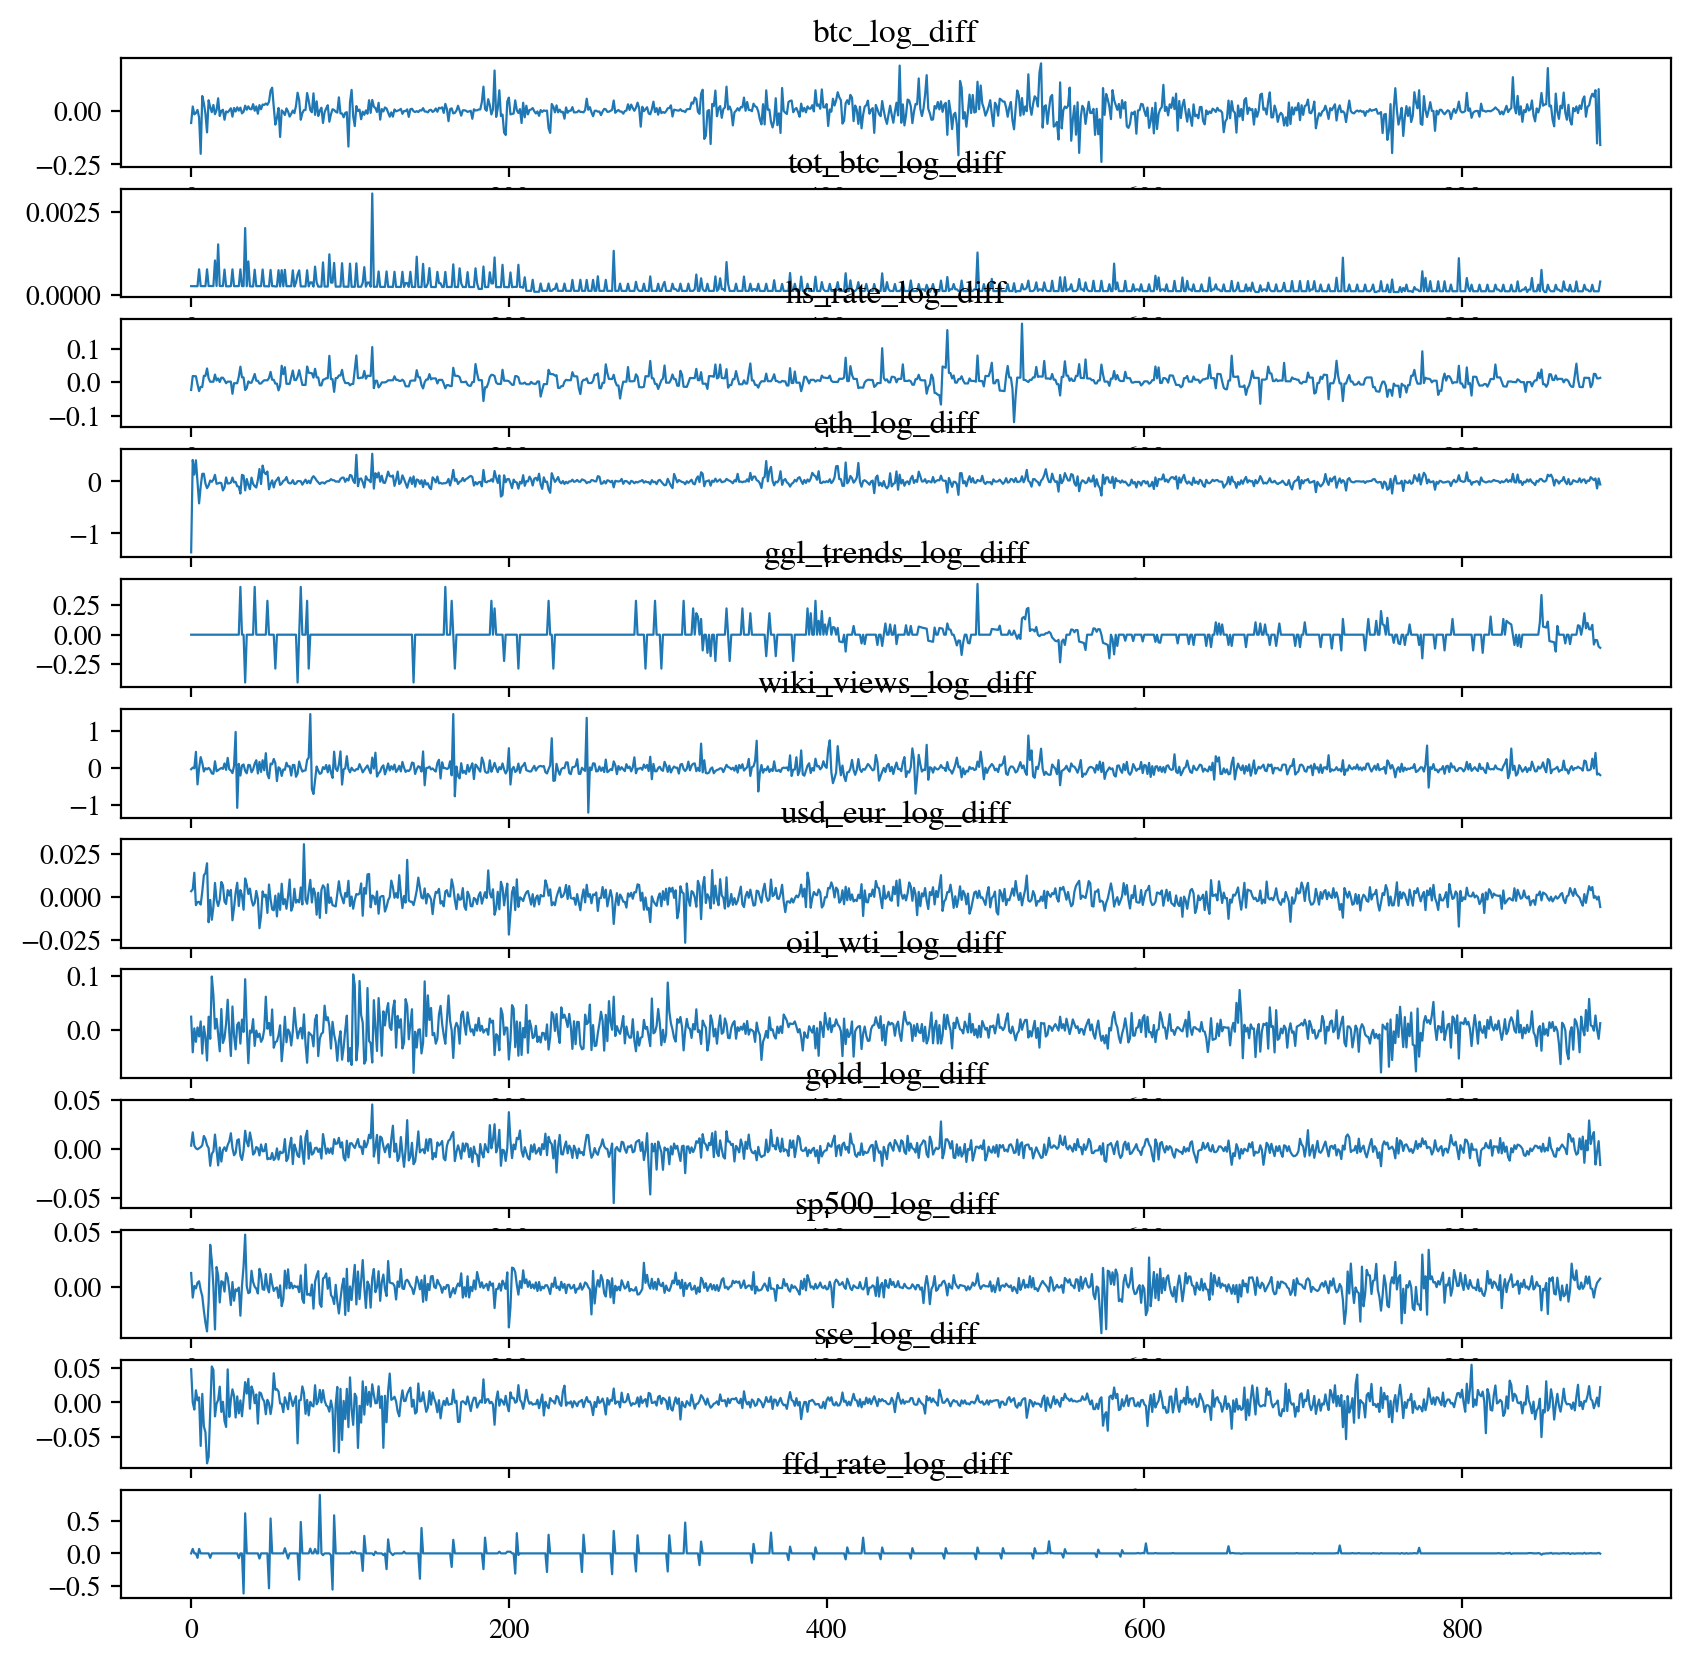

In [148]:
# transform var_fitted into data frame
# code taken from: https://stackoverflow.com/questions/51734180/converting-statsmodels-summary-object-to-pandas-dataframe
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })
    #Reordering
    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    return results_df

In [160]:
# read var coefficients for btc from .txt
var_btc_coefficients = pd.read_csv(save_plot_to+'VAR_coefficients.txt', delimiter='\s+', header=0)



TypeError: Index(...) must be called with a collection of some kind, 'coefficient' was passed